In [1]:
import keras 
import tensorflow as tf
import keras.backend.tensorflow_backend as K
from PIL import Image
from imutils import paths
from os import path
from keras.optimizers import Adam,RMSprop
import pandas as pd
keras.__version__
IMAGE_DIMS = (375,250,3)
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

Using TensorFlow backend.


In [2]:
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import img_to_array

In [3]:
date_arr = np.load('./new_date_arr.npy',allow_pickle=True)
dust_arr = np.load('./PM_delay_2.npy',allow_pickle=True)
wind_arr = np.load('./wind_arr.npy',allow_pickle=True)
humi_arr = np.load('./humi_arr.npy',allow_pickle=True)

In [4]:
import time

start = time.time() 
imagePaths = sorted(list(paths.list_images('./dataset/image')))
image_arr = []

for i in imagePaths:
    img_name = int(path.splitext(path.basename(i))[0])
    
    if img_name in date_arr :
        image = Image.open(i)
        image_crop = image.crop([380,0,600,200])
        image_crop = image_crop.resize((IMAGE_DIMS[0],IMAGE_DIMS[1]))
        image = image.resize((IMAGE_DIMS[0],IMAGE_DIMS[1]))
        image = np.concatenate((image_crop,image),axis=2)
        image = img_to_array(image)
        image_arr.append(image)
#         image = Image.open(i)
#         image = image.resize((IMAGE_DIMS[0],IMAGE_DIMS[1]))
#         image = img_to_array(image)
#         image_arr.append(image)
        
image_arr = np.array(image_arr, dtype="float") / 255.0        
print("[INFO] data matrix: {} images ({:.2f}MB)".format(len(imagePaths), image_arr.nbytes / (1024 * 1000.0)))

[INFO] data matrix: 18126 images (49025.39MB)


In [5]:
from sklearn.utils import shuffle



con_data_img = image_arr
con_data_val = dust_arr

print(wind_arr.shape)
con_data_wea = np.concatenate([wind_arr.reshape(len(wind_arr),1),humi_arr.reshape(len(humi_arr),1)], axis=1)


# 국내는 PM2.5이 16이상이면 보통
# for i in range(0,dustvalue.shape[0]):
#     if int(dustvalue[i]) > 0 :
#         con_data_img.append(data[i])
#         con_data_val.append(dustvalue[i])
#         con_data_wea.append(add_info[i])
        
con_data_img, con_data_val, con_data_wea = shuffle(np.array(con_data_img), np.array(con_data_val), np.array(con_data_wea), random_state=0)
con_data_img = np.array(con_data_img)
con_data_val = np.array(con_data_val)
con_data_wea = np.array(con_data_wea)

num = int(con_data_img.shape[0]*0.80)

train_img = con_data_img[:num]
train_val = con_data_val[:num]
train_wea = con_data_wea[:num]

test_img = con_data_img[num:]
test_val = con_data_val[num:]
test_wea = con_data_wea[num:]

print(con_data_img.shape)
print(train_img.shape)
print(test_img.shape)

print(con_data_img.shape)
print(con_data_val.shape)
print(con_data_wea.shape)


(11156,)
(11156, 250, 375, 6)
(8924, 250, 375, 6)
(2232, 250, 375, 6)
(11156, 250, 375, 6)
(11156,)
(11156, 2)


In [6]:
# import the necessary packages
from keras.models import Model, Sequential
from keras.layers import Input, LSTM, GRU, Embedding
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.core import Dropout
from keras.layers.core import Dense
from keras import backend as K

chanDim=-1
model = Sequential()

# CONV => RELU => POOL
model.add(Conv2D(32, (3, 3), padding="same",input_shape=(IMAGE_DIMS[1], IMAGE_DIMS[0],6)))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Dropout(0.25))

# (CONV => RELU) * 2 => POOL
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# (CONV => RELU) * 2 => POOL
model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(256, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(Conv2D(256, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())


image_input = Input(shape=(IMAGE_DIMS[1], IMAGE_DIMS[0],6))
encoded_image = model(image_input)

# 다음은 문제를 벡터로 인코딩할 숫자 모델을 정의합니다
numeric_input = Input(shape=(2,))
embedded_numeric = Embedding(input_dim=100, output_dim=128, input_length=2)(numeric_input)

# numeric_input2 = Dense(256, activation="linear")(embedded_numeric)
# print(embedded_numeric.shape)

#numeric_input2 = GRU(256)(embedded_numeric)
numeric_input2 = LSTM(128)(embedded_numeric)
# print(numeric_input2.shape)


# numeric_input = Input(shape=(8,), dtype='float32')
# numeric_input1 = Dense(1000,activation='linear')(numeric_input)
# numeric_input2 = Dense(100,activation='linear')(numeric_input1)

# 질문 벡터와 이미지 벡터를 연결해 봅시다:
merged = keras.layers.concatenate([encoded_image, numeric_input2],axis=-1)

output = Dense(1)(merged)

# 그리고 상층의 로지스틱 회귀를 수치에 대해 학습시킵니다:
# output = Dense(1024, activation='softmax')(merged)
# output = Dense(128, activation='softmax')(output)
# output = Dense(1)(output)
# 다음은 최종 모델입니다:
model = Model(inputs=[image_input, numeric_input], outputs=output)


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [7]:
# 파일 이름에 에포크 번호를 포함시킵니다(`str.format` 포맷)
checkpoint_path = "training_1/cp-{epoch:04d}.model"
checkpoint_dir = os.path.dirname(checkpoint_path)

# 다섯 번째 에포크마다 가중치를 저장하기 위한 콜백을 만듭니다
cp_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    verbose=1,
    save_weights_only=False,
    period=10)
#opt = RMSprop(lr=0.005, rho=0.9, epsilon=None, decay=0.0)
opt = Adam(lr=0.002, epsilon=None, decay=0.0)
model.compile(loss="mse", optimizer=opt,metrics=["accuracy"])
# logcosh, mes, 
H = model.fit([train_img,train_wea], train_val ,batch_size=48, epochs=200, callbacks=[cp_callback])


print("[INFO] serializing network...")
model.save('lstm-roi-PM-200-delay-2.model')



Instructions for updating:
Use tf.cast instead.
Epoch 1/200
8924/8924 [==============================] - 50s 6ms/step - loss: 523.5780 - acc: 0.0356
Epoch 2/200
8924/8924 [==============================] - 40s 5ms/step - loss: 452.7710 - acc: 0.0418
Epoch 3/200
8924/8924 [==============================] - 40s 4ms/step - loss: 422.3810 - acc: 0.0409
Epoch 4/200
8924/8924 [==============================] - 40s 4ms/step - loss: 408.3510 - acc: 0.0445
Epoch 5/200
8924/8924 [==============================] - 39s 4ms/step - loss: 384.1281 - acc: 0.0436
Epoch 6/200
8924/8924 [==============================] - 39s 4ms/step - loss: 377.6986 - acc: 0.0486
Epoch 7/200
8924/8924 [==============================] - 39s 4ms/step - loss: 376.8757 - acc: 0.0459
Epoch 8/200
8924/8924 [==============================] - 40s 4ms/step - loss: 356.8484 - acc: 0.0482
Epoch 9/200
8924/8924 [==============================] - 40s 4ms/step - loss: 349.2818 - acc: 0.0513
Epoch 10/200
8924/8924 [===================

8924/8924 [==============================] - 43s 5ms/step - loss: 41.1192 - acc: 0.1001
Epoch 76/200
8924/8924 [==============================] - 43s 5ms/step - loss: 45.6622 - acc: 0.0911
Epoch 77/200
8924/8924 [==============================] - 43s 5ms/step - loss: 47.4661 - acc: 0.0969
Epoch 78/200
8924/8924 [==============================] - 43s 5ms/step - loss: 53.5164 - acc: 0.0851
Epoch 79/200
8924/8924 [==============================] - 43s 5ms/step - loss: 46.9191 - acc: 0.0858
Epoch 80/200
8924/8924 [==============================] - 43s 5ms/step - loss: 43.5924 - acc: 0.0978

Epoch 00080: saving model to training_1/cp-0080.model
Epoch 81/200
8924/8924 [==============================] - 43s 5ms/step - loss: 39.2777 - acc: 0.1075
Epoch 82/200
8924/8924 [==============================] - 43s 5ms/step - loss: 35.3945 - acc: 0.0970
Epoch 83/200
8924/8924 [==============================] - 43s 5ms/step - loss: 39.0858 - acc: 0.1023
Epoch 84/200
8924/8924 [=========================

8924/8924 [==============================] - 43s 5ms/step - loss: 18.8634 - acc: 0.1318
Epoch 152/200
8924/8924 [==============================] - 43s 5ms/step - loss: 15.2008 - acc: 0.1440
Epoch 153/200
8924/8924 [==============================] - 43s 5ms/step - loss: 18.0137 - acc: 0.1412
Epoch 154/200
8924/8924 [==============================] - 42s 5ms/step - loss: 16.0783 - acc: 0.1525
Epoch 155/200
8924/8924 [==============================] - 43s 5ms/step - loss: 25.1925 - acc: 0.1261
Epoch 156/200
8924/8924 [==============================] - 43s 5ms/step - loss: 26.6809 - acc: 0.1195
Epoch 157/200
8924/8924 [==============================] - 43s 5ms/step - loss: 29.3426 - acc: 0.1186
Epoch 158/200
8924/8924 [==============================] - 43s 5ms/step - loss: 24.6899 - acc: 0.1273
Epoch 159/200
8924/8924 [==============================] - 43s 5ms/step - loss: 18.1462 - acc: 0.1370
Epoch 160/200
8924/8924 [==============================] - 43s 5ms/step - loss: 18.2009 - acc: 0

In [8]:
print(image_arr.shape)
print(dust_arr.shape)

print(wind_arr.shape)
print(humi_arr.shape)

print(test_img.shape)
print(test_wea.shape)

print(model.predict([test_img, test_wea]))

y_pred = np.squeeze(np.round(model.predict([test_img, test_wea]).astype(np.int64)))

print(test_val.shape)
print(y_pred.shape)

(11156, 250, 375, 6)
(11156,)
(11156,)
(11156,)
(2232, 250, 375, 6)
(2232, 2)
[[ 3.753935 ]
 [25.880316 ]
 [34.432407 ]
 ...
 [ 9.356528 ]
 [ 9.272549 ]
 [ 4.2867575]]
(2232,)
(2232,)


In [9]:
# print(con_data_val.shape)
# print(train_val.shape)
# print(test_val.shape)
print(con_data_img.shape)
print(con_data_val.shape)
print(con_data_wea.shape)

(11156, 250, 375, 6)
(11156,)
(11156, 2)


In [10]:
RMSE = mean_squared_error(test_val.astype(np.int64), y_pred)**0.5
R2SCORE = r2_score(test_val.astype(np.int64), y_pred)

print("RMSE 는 : " , RMSE)
print("R2SCORE 는 : ", R2SCORE)

RMSE 는 :  31.420392095365763
R2SCORE 는 :  -1.3889704658590598


Text(70, 50, 'R-squared = -1.39')

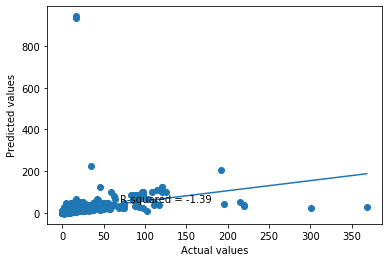

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt

test_val=np.squeeze(test_val.astype(np.int64))

plt.scatter(test_val,y_pred)
plt.xlabel('Actual values')
plt.ylabel('Predicted values')

plt.plot(np.unique(test_val), np.poly1d(np.polyfit(test_val, y_pred, 1))(np.unique(test_val)))

plt.text(70, 50, 'R-squared = %0.2f' % R2SCORE)

In [12]:
np.round(test_val.astype(np.int64))
np.where(test_val >50)

(array([   2,   27,   77,  125,  143,  192,  198,  269,  274,  309,  336,
         357,  386,  454,  485,  507,  511,  521,  545,  546,  556,  570,
         581,  616,  641,  643,  671,  687,  738,  746,  752,  753,  770,
         775,  799,  825,  857,  964,  986, 1109, 1136, 1217, 1225, 1244,
        1262, 1280, 1397, 1433, 1434, 1437, 1491, 1508, 1546, 1547, 1648,
        1670, 1680, 1681, 1716, 1752, 1753, 1811, 1855, 1930, 2026, 2072,
        2075, 2120, 2133, 2137, 2171, 2207], dtype=int64),)

예측값 :  41
실제값 :  27


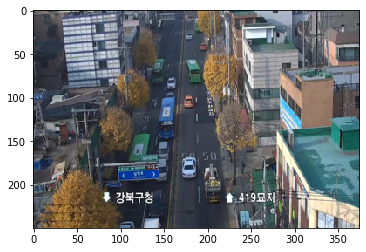

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt
i=2083

plt.imshow(test_img[i][:,:,3:])
print("예측값 : ", y_pred[i])
print("실제값 : ", test_val[i])

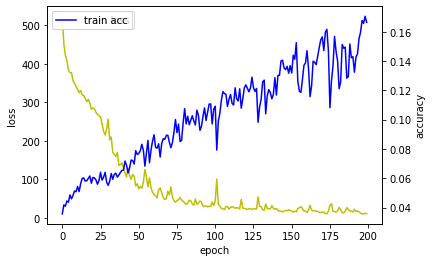

In [14]:
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots()
acc_ax = loss_ax.twinx()

loss_ax.plot(H.history['loss'], 'y', label='train loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
loss_ax.legend(loc='upper left')

acc_ax.plot(H.history['acc'], 'b', label='train acc')
acc_ax.set_ylabel('accuracy')
acc_ax.legend(loc='upper left')

plt.show()

In [15]:
np.save('pm10_con_data_val.npy',con_data_val)